<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
 <b>Cattle Breed Identification/Detection</b>

<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">In this project we are using the Indian Cattle dataset</span>
</div>



<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
 <b>Indegenous Cattle Breed Classifier Model</b>

<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">
### Problem Statement:
In our country we have a ton of different cattle breeds. Each breed is unique and they transmit different characterstics in term of milk quality etc.
Their price vary based on their breed. It is very hard for a farmer to correctly identify the correct breed since some breeds seem similar in color and body structure.

### Proposed solution
We want to build an AI based App which will process the image and come up with correct breed name. With this app they will get a range of prediction with assigned probability.
</span>
</div>

In [1]:
# Import Libraries

# Basics need Libraries
import os
import random
import numpy as np 
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# Import PyTorch and torchvision Libraries
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import datasets, models
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from sklearn.model_selection import train_test_split
from collections import Counter

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
except:
    import subprocess
    subprocess.check_call(['pip', 'install', '-U', 'albumentations', '--quiet'])
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

In [2]:
# Check the versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [3]:
# Hyperparameters Tunning
SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS = 40
INITIAL_LR = 0.0001
WEIGHT_DECAY = 0.01
MIXUP_ALPHA = 0.2
LABEL_SMOOTHING = 0.1
PATIENCE = 8

In [4]:
# For Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Setup device agnostic code
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">

<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Data Loading</span>
</div>


In [6]:
import kagglehub
path = kagglehub.dataset_download("atharvadarpude/indian-cattle-image-dataset")
path = os.path.join(path, 'cattle')
print(f"Dataset path: {path}")

# Load dataset with ImageFolder
cattle_dataset = datasets.ImageFolder(path, transform=None)

# Get the class names
classes = cattle_dataset.classes
print(f"Total classes: {len(classes)}")
print(f"Total Images: {len(cattle_dataset)}")

# Check the Variability of classes
class_names = cattle_dataset.classes
print(f"Classes/Categories Name: {class_names}")

# Check the index of classes
class_to_idx = cattle_dataset.class_to_idx
print(f"Encoded Labels for each category: {class_to_idx}")

Dataset path: /kaggle/input/indian-cattle-image-dataset/cattle
Total classes: 50
Total Images: 8531
Classes/Categories Name: ['Amritmahal', 'Ayrshire', 'Bargur', 'Dangi', 'Deoni', 'Gir', 'Hallikar', 'Hariana', 'Himachali Pahari', 'Kangayam', 'Kankrej', 'Kenkatha', 'Khariar', 'Khillari', 'Konkan Kapila', 'Kosali', 'Krishna_Valley', 'Ladakhi', 'Lakhimi', 'Malnad_gidda', 'Mewati', 'Nari', 'Nimari', 'Ongole', 'Poda Thirupu', 'Pulikulam', 'Punganur', 'Purnea', 'Rathi', 'Red kandhari', 'Red_Sindhi', 'Sahiwal', 'Shweta Kapila', 'Tharparkar', 'Umblachery', 'Vechur', 'bachaur', 'badri', 'bhelai', 'dagri', 'gangatari', 'gaolao', 'ghumsari', 'kherigarh', 'malvi', 'motu', 'nagori', 'ponwar', 'siri', 'thutho']
Encoded Labels for each category: {'Amritmahal': 0, 'Ayrshire': 1, 'Bargur': 2, 'Dangi': 3, 'Deoni': 4, 'Gir': 5, 'Hallikar': 6, 'Hariana': 7, 'Himachali Pahari': 8, 'Kangayam': 9, 'Kankrej': 10, 'Kenkatha': 11, 'Khariar': 12, 'Khillari': 13, 'Konkan Kapila': 14, 'Kosali': 15, 'Krishna_Valley

<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">

<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Exploratory Data Analysis --> EDA </span>
</div>


Size of Image: (250, 167)


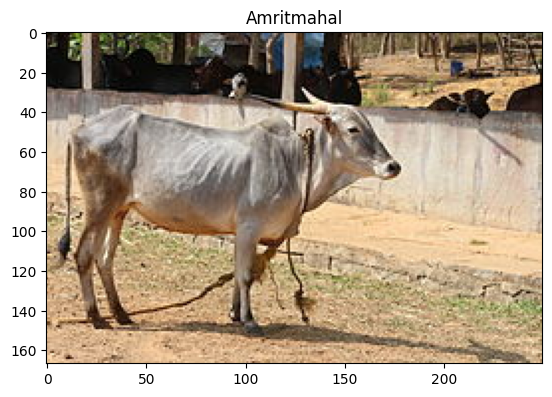

In [7]:
# Visualize The Data
image, label = cattle_dataset[0]
print(f"Size of Image: {image.size}")
plt.imshow(image)
plt.title(class_names[label])
plt.show()

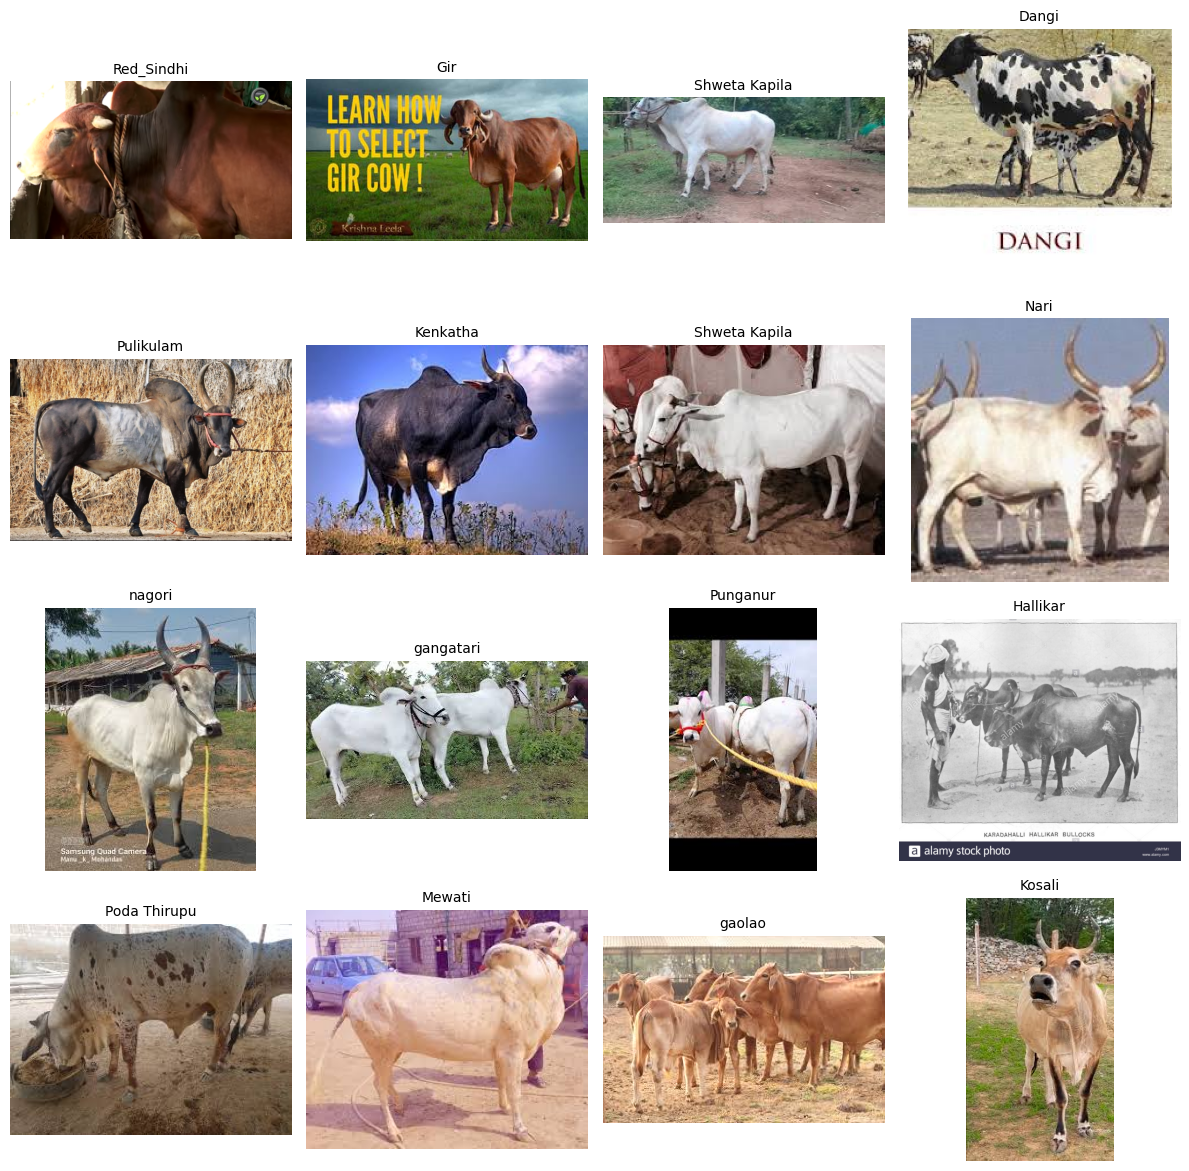

In [8]:
# plot more images
fig = plt.figure(figsize=(12,12))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(200, len(cattle_dataset), size=[1]).item()
    image, label = cattle_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image)
    plt.title(class_names[label], fontsize=10) # Reduce title size for Better User Experience
    plt.tight_layout()
    plt.axis(False)

<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Count Images Per Class</span>
</div>


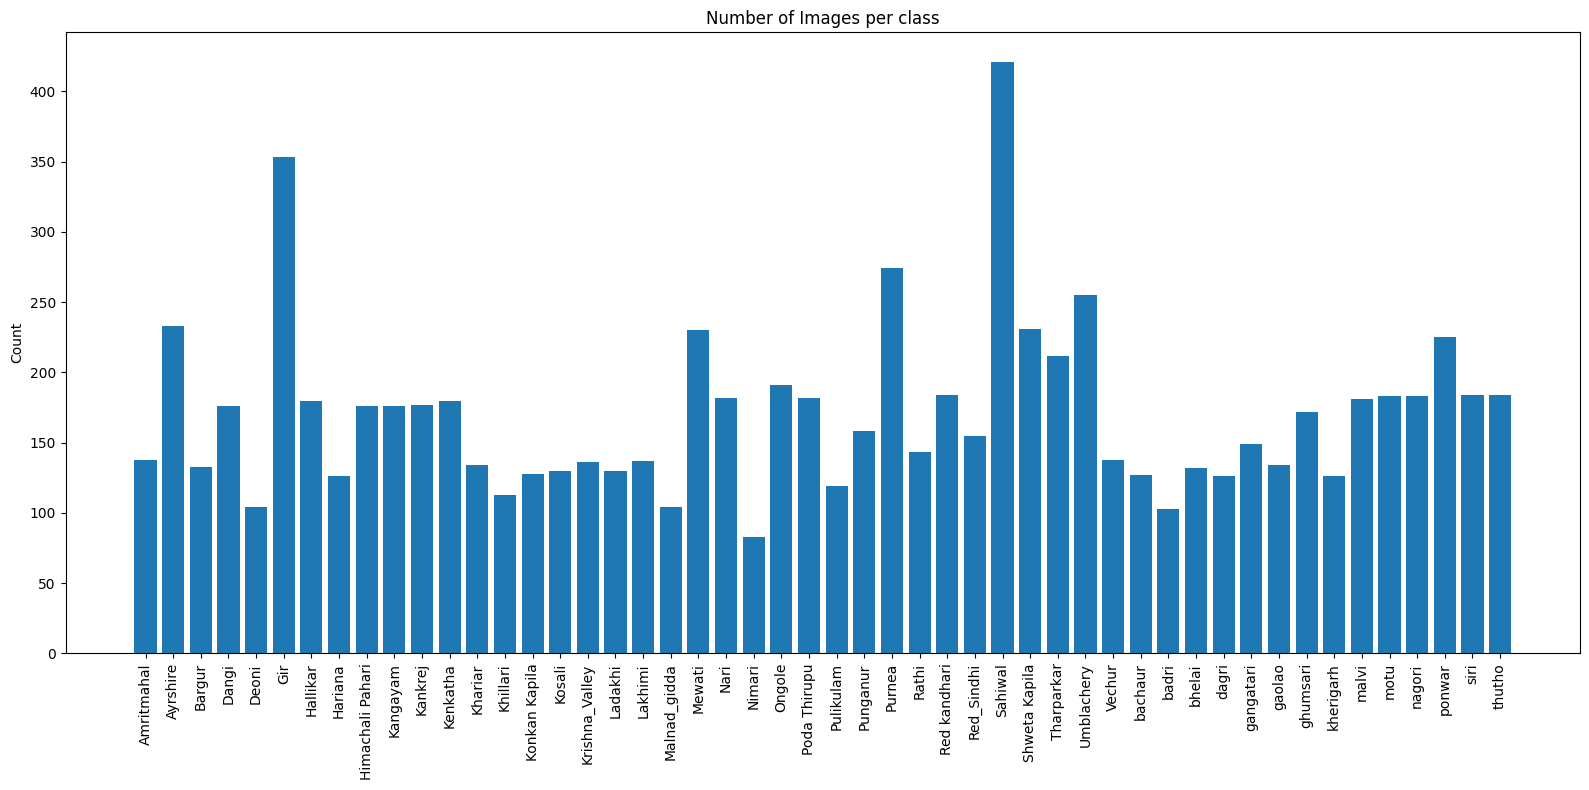

In [9]:
# Count Images Per Class
from collections import Counter

# Count occurrences of each Label efficiently
label_counts = Counter(label for image, label in cattle_dataset)

# Map Label indices to class names
class_counts = {classes[idx]: label_counts[idx] for idx in range(len(classes))}

# Visualize class distribution
plt.figure(figsize=(16,8))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Number of Images per class")
plt.tight_layout()
plt.show()

In [10]:
# Functions for a getting a frame of specified shape
"""
input - no.of rows, columns and fig size of a frame
output - the resultant frame
"""

def get_image_frame(nrows=1, ncols=1, figsize=(36,24)):
  # create subplots
  fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
  if(ncols==1):
    return [axs]
  return axs

Image Transformation

*   Image to pixel values transformations
*   Image Resizing


In [11]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
image_to_pixel_transform = transforms.ToTensor()
cattle_dataset_in_pixels = ImageFolder(root=path, transform=image_to_pixel_transform)
print(cattle_dataset_in_pixels[0])

(tensor([[[0.0118, 0.0902, 0.1333,  ..., 0.5098, 0.4000, 0.4275],
         [0.1490, 0.0667, 0.0627,  ..., 0.4039, 0.3686, 0.4157],
         [0.0314, 0.1255, 0.1529,  ..., 0.2784, 0.2471, 0.3098],
         ...,
         [0.9373, 0.9725, 1.0000,  ..., 0.8392, 0.7451, 0.9059],
         [0.9529, 0.8471, 0.9843,  ..., 0.7961, 0.8196, 0.6392],
         [0.9373, 0.9373, 0.9569,  ..., 0.8118, 0.9098, 0.7255]],

        [[0.0078, 0.0824, 0.1373,  ..., 0.4745, 0.3725, 0.4000],
         [0.1255, 0.0510, 0.0510,  ..., 0.3804, 0.3529, 0.4000],
         [0.0000, 0.0902, 0.1255,  ..., 0.2549, 0.2235, 0.2863],
         ...,
         [0.7922, 0.8275, 0.8627,  ..., 0.7216, 0.6196, 0.7804],
         [0.8078, 0.7020, 0.8392,  ..., 0.6706, 0.6863, 0.5059],
         [0.7922, 0.7922, 0.8118,  ..., 0.6784, 0.7804, 0.5882]],

        [[0.0000, 0.0235, 0.1059,  ..., 0.3216, 0.2078, 0.2353],
         [0.0627, 0.0039, 0.0235,  ..., 0.2549, 0.2157, 0.2627],
         [0.0000, 0.0549, 0.1020,  ..., 0.1608, 0.1216, 0

In [12]:
# Function for transforming images to pixels
"""
input - tensors and corresponding labels
output - image

"""

def display_images_from_tensors(tensors,labels):
  # get the count of images from tensors and labels
  num_images = len(tensors)
  print(f"num_images :{num_images}")
  axs = get_image_frame(1,num_images,(12,12))
  for i in range(num_images):
    axs[i].imshow(tensors[i].permute(1,2,0))
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis("off")
  plt.show()

num_images :2


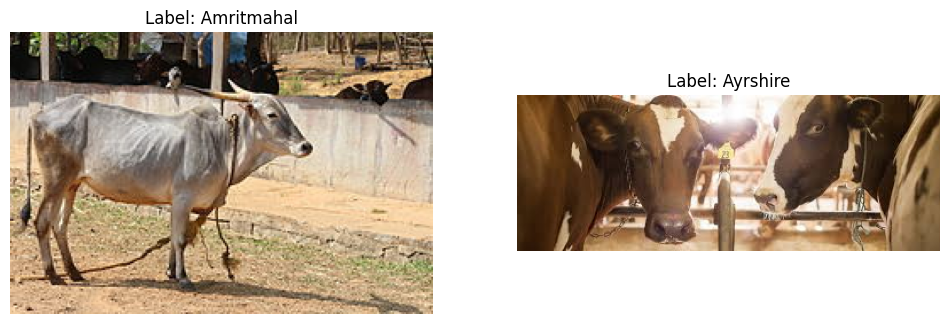

In [13]:
display_images_from_tensors([cattle_dataset_in_pixels[0][0], cattle_dataset_in_pixels[304][0]],["Amritmahal","Ayrshire"])

In [14]:
from torchvision.transforms import transforms
transformation_chain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

# Applying transformation
cattle_dataset_transformed = ImageFolder(path, transform=transformation_chain)

num_images :2


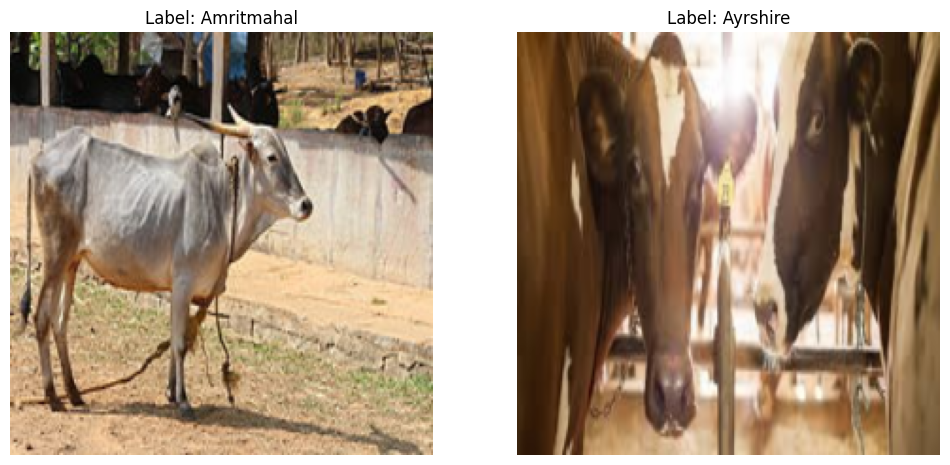

In [15]:
display_images_from_tensors([cattle_dataset_transformed[0][0], cattle_dataset_transformed[304][0]],["Amritmahal","Ayrshire"])

*Quick Observation : Images seem have similar size and Quality seems a bit reduced wrt previous one*

* Image Rotations and Flipping

In [16]:
# rotate and flip the images
from torchvision.transforms import transforms
transformation_chain = transforms.Compose([
    transforms.RandomRotation(0.5),
    transforms.ToTensor(),
    transforms.Resize((224,224))
])
# apply rotate and flip the images transformations
cattle_dataset_transformed = ImageFolder(path,transform=transformation_chain)

num_images :2


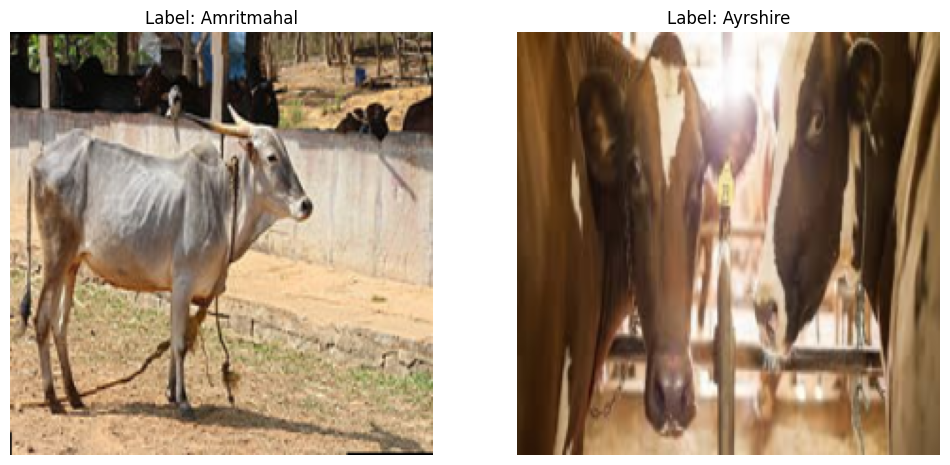

In [17]:
display_images_from_tensors([cattle_dataset_transformed[0][0], cattle_dataset_transformed[304][0]],["Amritmahal","Ayrshire"])

* Image Cropping

In [18]:
#cropping the image from center with size 32 by 32
from torchvision.transforms import transforms
transformation_chain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.CenterCrop(64)
])

# apply rotate and flip the images transformations
cattle_dataset_transformed = ImageFolder(path,transform=transformation_chain)

num_images :2


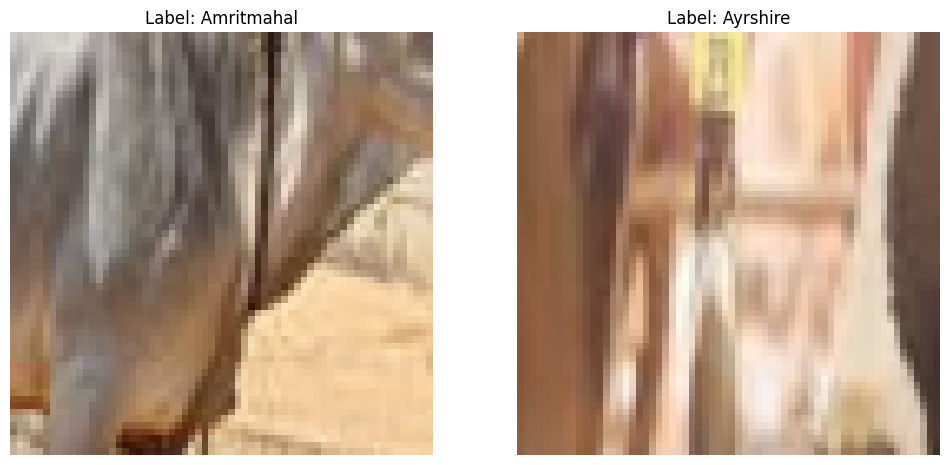

In [19]:
display_images_from_tensors([cattle_dataset_transformed[0][0], cattle_dataset_transformed[304][0]],["Amritmahal","Ayrshire"])

* Image Normalization

In [20]:
# transformed the image using pre-determined values
from torchvision.transforms import transforms
transformation_chain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.3,0.3,0.3], std=[0.3, 0.3, 0.3])
])

# apply images normalize transformations
cattle_dataset_transformed = ImageFolder(path,transform=transformation_chain)

num_images :2


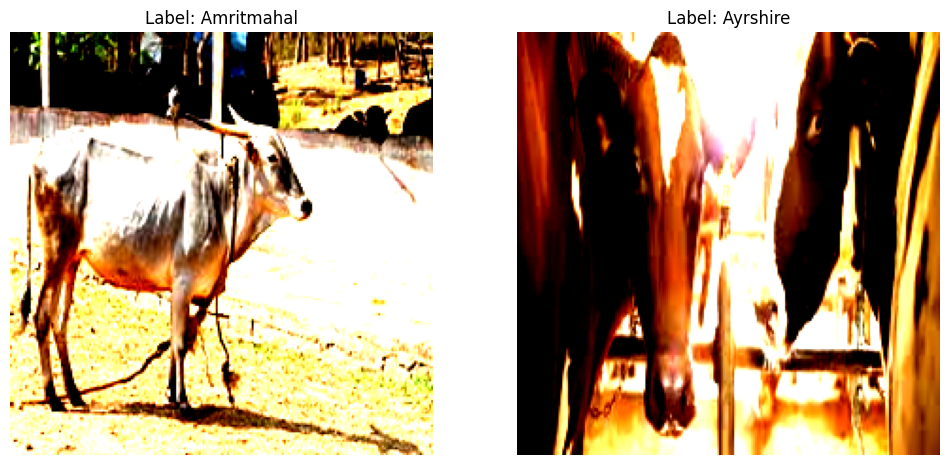

In [21]:
display_images_from_tensors([cattle_dataset_transformed[0][0], cattle_dataset_transformed[304][0]],["Amritmahal","Ayrshire"])

* Gray Scaling

In [22]:
# transform the image to B & W
# transformed the image using pre-determined values
from torchvision.transforms import transforms
transformation_chain = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

# here applying Grayscale image transformations
cattle_dataset_transformed = ImageFolder(root=path,transform=transformation_chain)

num_images :2


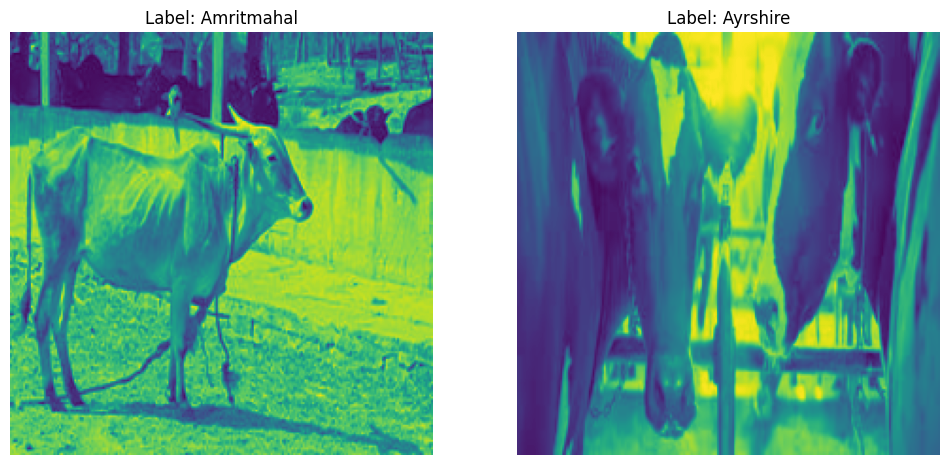

In [23]:
display_images_from_tensors([cattle_dataset_transformed[0][0], cattle_dataset_transformed[304][0]],["Amritmahal","Ayrshire"])

In [24]:
# definie the function for chaining transformation
def get_transform(transform_list):
  transform = transforms.Compose(transform_list)
  return transform

num_images :2


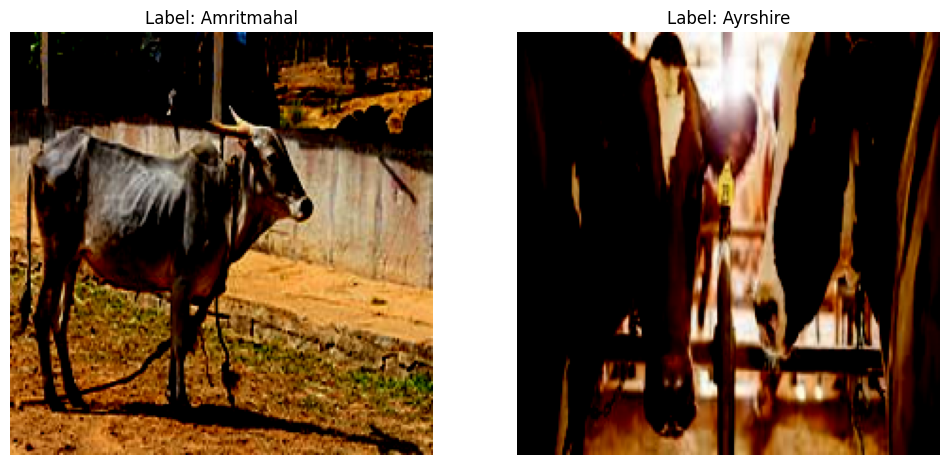

In [25]:
#test out above functions
transformation_chain = get_transform([transforms.Resize((224,224)),transforms.RandomRotation(0.5),transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])
cattle_dataset_transformed = ImageFolder(root=path,transform=transformation_chain)
display_images_from_tensors([cattle_dataset_transformed[0][0], cattle_dataset_transformed[304][0]],["Amritmahal","Ayrshire"])

<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Data Preparation, Transfer Learning, Training and Evaluation</span>
</div>


* Data Augmentation

In [26]:
class AlbumentationsDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.targets = [label for _, label in self.subset]

    def __getitem__(self, idx):
        image, target = self.subset[idx]
        if self.transform is not None:
            image_np = np.array(image)
            transformed = self.transform(image=image_np)
            image = transformed["image"]
        return image, target

    def __len__(self):
        return len(self.subset)

In [27]:
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.RandomCrop(height=224, width=224),

    # Geometric augmentations (STRONGER)
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.15,
        scale_limit=0.2,
        rotate_limit=20,
        border_mode=0,
        p=0.6
    ),
    A.Perspective(scale=(0.05, 0.15), p=0.4),

    # Color augmentations (STRONGER)
    A.OneOf([
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=15, p=1.0),
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1.0),
    ], p=0.6),

    # Noise and blur
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.MotionBlur(blur_limit=5, p=1.0),
    ], p=0.3),

    # Random brightness/contrast
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),

    # Cutout for regularization
    A.CoarseDropout(
        max_holes=4,
        max_height=32,
        max_width=32,
        min_holes=1,
        fill_value=0,
        p=0.3
    ),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

* Data Preparation

In [28]:
base_dataset = datasets.ImageFolder(root=path)
num_classes = len(base_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Total images: {len(base_dataset)}")

# Get mapping from class name to index
class_to_idx = base_dataset.class_to_idx

# Reverse the mapping to get index to class name
idx_to_class = {v : k for k, v in class_to_idx.items()}

# Split dataset
total_images = len(base_dataset)
train_idx, temp_idx = train_test_split(
    list(range(total_images)),
    test_size=0.3,
    random_state=SEED,
    stratify=[label for _, label in base_dataset.samples]
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=SEED,
    stratify=[base_dataset.samples[i][1] for i in temp_idx]
)


Number of classes: 50
Total images: 8531


In [29]:
# Create subsets
train_subset = Subset(base_dataset, train_idx)
val_subset = Subset(base_dataset, val_idx)
test_subset = Subset(base_dataset, test_idx)

# Apply transformations
train_dataset = AlbumentationsDataset(train_subset, train_transform)
val_dataset = AlbumentationsDataset(val_subset, test_val_transform)
test_dataset = AlbumentationsDataset(test_subset, test_val_transform)


In [30]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True
)


<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Transfer learning Model - EfficientNetV2-S</span>
</div>
 

In [31]:
class CattleBreedClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CattleBreedClassifier, self).__init__()

        # Using EfficientNetV2-S 
        if pretrained:
            weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
            self.backbone = efficientnet_v2_s(weights=weights)
        else:
            self.backbone = efficientnet_v2_s(weights=None)

        # Get features
        in_features = self.backbone.classifier[1].in_features

        # classifier with dropout
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, targets=None, mixup_alpha=0.2, training=True):
        if training and targets is not None and mixup_alpha > 0:
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            batch_size = x.size(0)
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index]
            y_a, y_b = targets, targets[index]

            outputs = self.backbone(mixed_x)
            return outputs, y_a, y_b, lam
        else:
            outputs = self.backbone(x)
            return outputs


In [32]:
def mixup_loss(loss_fn, pred, y_a, y_b, lam):
    return lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)

In [33]:
def train_epoch(model, loader, loss_fn, optimizer, device, mixup_alpha):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc="Training", leave=False)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, targets_a, targets_b, lam = model(inputs, labels, mixup_alpha, training=True)
        loss = mixup_loss(loss_fn, outputs, targets_a, targets_b, lam)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (lam * predicted.eq(targets_a).sum().float() +
                   (1 - lam) * predicted.eq(targets_b).sum().float()).item()

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total

In [34]:
def evaluate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    loop = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass (no mixup during evaluation)
            outputs = model(inputs, training=False)
            loss = loss_fn(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loop.set_postfix(loss=loss.item(), acc=correct/total)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Training and Evaluation on Indian-cattle-buffaloes-breeds</span>
</div>
 

In [35]:
def train_model():
    model = CattleBreedClassifier(num_classes=num_classes, pretrained=True)
    model = model.to(device)

    # Loss and optimizer
    loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

    # Cosine annealing scheduler )
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    best_val_acc = 0.0
    patience_counter = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, loss_fn, optimizer, device, MIXUP_ALPHA
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc,all_preds, all_labels = evaluate(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Step scheduler
        scheduler.step()

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cattle_classifier_v2.pth')
            print(f"✓ NEW BEST MODEL - Val Acc: {val_acc*100:.2f}%")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE - Best Validation Accuracy: {best_val_acc*100:.2f}%")
    print(f"{'='*60}")
    return model, best_val_acc,train_losses,train_accs,val_losses,val_accs

In [36]:
model, best_val_acc,train_losses,train_accs,val_losses,val_accs = train_model()
print(f"\nFinal Best Validation Accuracy: {best_val_acc*100:.2f}%")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 173MB/s] 



Epoch 1/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.6970 | Train Acc: 10.68% | Val Loss: 2.9490 | Val Acc: 30.78%
✓ NEW BEST MODEL - Val Acc: 30.78%

Epoch 2/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 3.0524 | Train Acc: 27.55% | Val Loss: 2.4149 | Val Acc: 45.00%
✓ NEW BEST MODEL - Val Acc: 45.00%

Epoch 3/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.7631 | Train Acc: 36.02% | Val Loss: 2.1663 | Val Acc: 50.94%
✓ NEW BEST MODEL - Val Acc: 50.94%

Epoch 4/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.6118 | Train Acc: 40.84% | Val Loss: 2.0325 | Val Acc: 55.86%
✓ NEW BEST MODEL - Val Acc: 55.86%

Epoch 5/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.4853 | Train Acc: 44.51% | Val Loss: 1.9198 | Val Acc: 61.41%
✓ NEW BEST MODEL - Val Acc: 61.41%

Epoch 6/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.3504 | Train Acc: 49.81% | Val Loss: 1.8362 | Val Acc: 61.95%
✓ NEW BEST MODEL - Val Acc: 61.95%

Epoch 7/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.3283 | Train Acc: 50.89% | Val Loss: 1.7853 | Val Acc: 63.59%
✓ NEW BEST MODEL - Val Acc: 63.59%

Epoch 8/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.2286 | Train Acc: 54.39% | Val Loss: 1.7625 | Val Acc: 64.38%
✓ NEW BEST MODEL - Val Acc: 64.38%

Epoch 9/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.2754 | Train Acc: 53.01% | Val Loss: 1.7459 | Val Acc: 64.45%
✓ NEW BEST MODEL - Val Acc: 64.45%

Epoch 10/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.1618 | Train Acc: 57.26% | Val Loss: 1.7415 | Val Acc: 64.61%
✓ NEW BEST MODEL - Val Acc: 64.61%

Epoch 11/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.2563 | Train Acc: 53.78% | Val Loss: 1.7361 | Val Acc: 63.91%

Epoch 12/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.2788 | Train Acc: 53.33% | Val Loss: 1.6841 | Val Acc: 66.41%
✓ NEW BEST MODEL - Val Acc: 66.41%

Epoch 13/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.1081 | Train Acc: 57.93% | Val Loss: 1.6537 | Val Acc: 67.27%
✓ NEW BEST MODEL - Val Acc: 67.27%

Epoch 14/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.9987 | Train Acc: 61.85% | Val Loss: 1.6434 | Val Acc: 66.95%

Epoch 15/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 2.0192 | Train Acc: 61.33% | Val Loss: 1.6125 | Val Acc: 68.44%
✓ NEW BEST MODEL - Val Acc: 68.44%

Epoch 16/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.9324 | Train Acc: 64.01% | Val Loss: 1.6096 | Val Acc: 67.81%

Epoch 17/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.9050 | Train Acc: 66.07% | Val Loss: 1.6106 | Val Acc: 68.67%
✓ NEW BEST MODEL - Val Acc: 68.67%

Epoch 18/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.8305 | Train Acc: 67.76% | Val Loss: 1.5935 | Val Acc: 69.14%
✓ NEW BEST MODEL - Val Acc: 69.14%

Epoch 19/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7968 | Train Acc: 68.94% | Val Loss: 1.6041 | Val Acc: 69.45%
✓ NEW BEST MODEL - Val Acc: 69.45%

Epoch 20/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7680 | Train Acc: 70.32% | Val Loss: 1.6018 | Val Acc: 68.98%

Epoch 21/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7248 | Train Acc: 71.60% | Val Loss: 1.6009 | Val Acc: 70.47%
✓ NEW BEST MODEL - Val Acc: 70.47%

Epoch 22/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7152 | Train Acc: 71.93% | Val Loss: 1.5893 | Val Acc: 70.78%
✓ NEW BEST MODEL - Val Acc: 70.78%

Epoch 23/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7220 | Train Acc: 71.50% | Val Loss: 1.6159 | Val Acc: 70.31%

Epoch 24/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7177 | Train Acc: 72.33% | Val Loss: 1.6015 | Val Acc: 70.62%

Epoch 25/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6526 | Train Acc: 74.55% | Val Loss: 1.5904 | Val Acc: 70.47%

Epoch 26/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6751 | Train Acc: 73.63% | Val Loss: 1.6004 | Val Acc: 71.02%
✓ NEW BEST MODEL - Val Acc: 71.02%

Epoch 27/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.7744 | Train Acc: 70.76% | Val Loss: 1.6186 | Val Acc: 70.23%

Epoch 28/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.5950 | Train Acc: 76.76% | Val Loss: 1.5995 | Val Acc: 70.39%

Epoch 29/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6066 | Train Acc: 76.17% | Val Loss: 1.5944 | Val Acc: 70.62%

Epoch 30/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6117 | Train Acc: 75.42% | Val Loss: 1.5932 | Val Acc: 70.94%

Epoch 31/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6752 | Train Acc: 73.24% | Val Loss: 1.6265 | Val Acc: 69.77%

Epoch 32/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6653 | Train Acc: 73.72% | Val Loss: 1.6913 | Val Acc: 68.20%

Epoch 33/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.8098 | Train Acc: 69.88% | Val Loss: 1.6958 | Val Acc: 68.05%

Epoch 34/40


Training:   0%|          | 0/187 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6146 | Train Acc: 74.42% | Val Loss: 1.7148 | Val Acc: 67.97%
Early stopping at epoch 34

TRAINING COMPLETE - Best Validation Accuracy: 71.02%

Final Best Validation Accuracy: 71.02%


<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Loading and Evaluating on Test Data</span>
</div>
 

In [37]:
# Load best model
model.load_state_dict(torch.load('best_cattle_classifier_v2.pth',weights_only=True))

<All keys matched successfully>

In [38]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

In [39]:
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, loss_fn=loss_fn,device=device)
print(f"\nTest Loss: {test_loss:.4f} | Test acc:{test_acc*100:.2f}%")

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]


Test Loss: 1.5958 | Test acc:70.08%



<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Visualization and Analysis</span>
</div>
 

   * Plot Training and Validation Curves
   * Plot Testing Curves


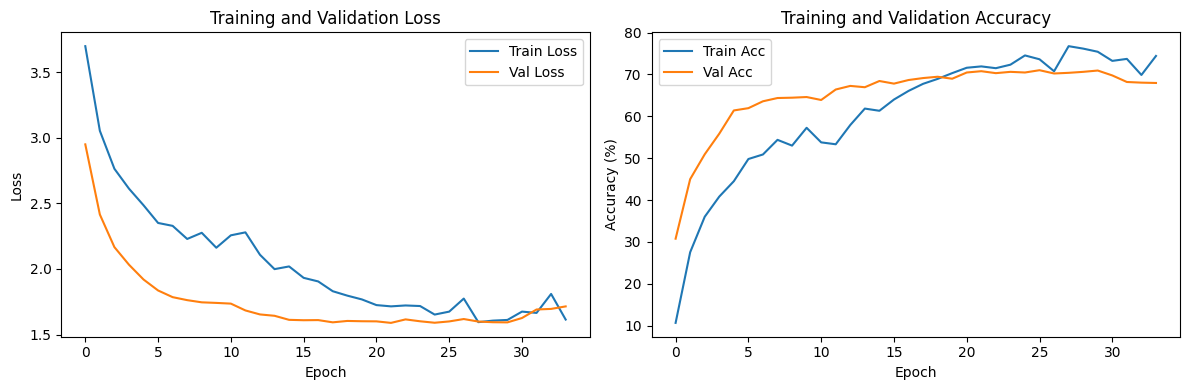

In [40]:
 # Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot([acc*100 for acc in train_accs], label='Train Acc')
plt.plot([acc*100 for acc in val_accs], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


**# Confusion Matrix**

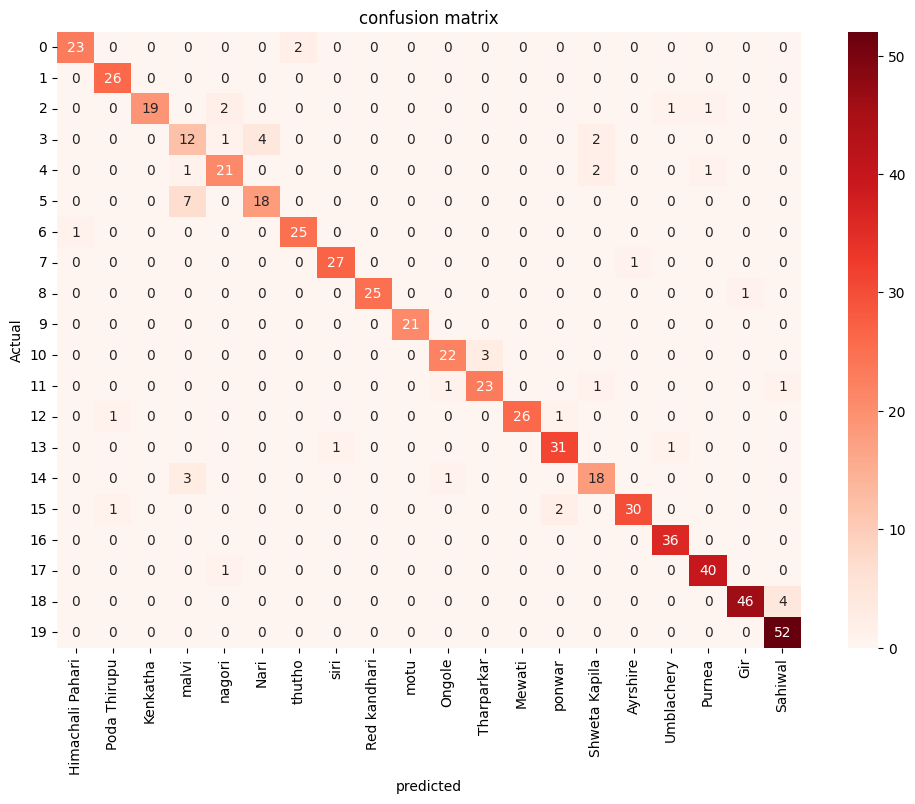

In [47]:
from sklearn.metrics import confusion_matrix
class_display_names =[]
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Here Comes A problem But we Can Arrange it by small adjustments
# We have 50 total classes of indian cattle breeds and plotting all will make hard to read &  size of matrix will increase so that's problematic while visualize
# So We will take 20 classes

if len(class_names)>20:
  # Find the Most frequent classes
  unique, counts = np.unique(test_labels, return_counts=True) # This will returns class labels (unique) and their frequencies (counts)
  top_indices = np.argsort(counts)[-20:]
  top_classes = unique[top_indices]


  # Filter labels & predictions because we want only labels which belongs to that 20 classes
  mask = np.isin(test_labels, top_classes)
  filtered_lables, filtered_preds = np.array(test_labels)[mask], np.array(test_preds)[mask]

  # Compute reduced confusion matrix
  cm = confusion_matrix(filtered_lables, filtered_preds, labels= top_classes)
  class_display_names = [class_names[i] for i in top_classes]

# Plot the confusion matrix
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',xticklabels=class_display_names)
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.title('confusion matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

**# Classification Report**

In [48]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_preds, target_names= class_names))

                  precision    recall  f1-score   support

      Amritmahal       0.35      0.40      0.37        20
        Ayrshire       0.86      0.86      0.86        35
          Bargur       0.86      0.90      0.88        20
           Dangi       0.85      0.85      0.85        26
           Deoni       0.67      0.62      0.65        16
             Gir       0.82      0.87      0.84        53
        Hallikar       0.71      0.74      0.73        27
         Hariana       0.67      0.53      0.59        19
Himachali Pahari       0.85      0.85      0.85        27
        Kangayam       0.77      0.77      0.77        26
         Kankrej       0.74      0.77      0.75        26
        Kenkatha       0.90      0.70      0.79        27
         Khariar       0.62      0.65      0.63        20
        Khillari       0.62      0.29      0.40        17
   Konkan Kapila       0.94      0.89      0.92        19
          Kosali       1.00      0.65      0.79        20
  Krishna_Val

<div style="
  background: linear-gradient(135deg, rgba(255,255,255,0.7), rgba(240,245,255,0.5), rgba(250,240,255,0.4));
  backdrop-filter: blur(16px) saturate(150%);
  -webkit-backdrop-filter: blur(16px) saturate(150%);
  border: 1px solid rgba(255,255,255,0.6);
  border-radius: 20px;
  padding: 30px 28px;
  text-align: left;
  font-family: 'SF Pro Display', -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
  color: #1a1a1a;
  font-weight: 700;
  font-size: 26px;
  letter-spacing: 0.3px;
  box-shadow: 0 6px 18px rgba(0,0,0,0.05);
  margin: 30px 0;
">
  
<span style="
  display:block;
  font-size:18px;
  font-weight:500;
  color:#444;
  margin-top:10px;
  letter-spacing:0.2px;
  text-shadow:none;
">Inference Function for Single Images</span>
</div>



In [75]:
def predict_breed(model, image_path, idx_to_class, device):
    from PIL import UnidentifiedImageError
    import torchvision.transforms.v2 as transforms
    


    try:
        # Load and Preprocess the image
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"X -> File Not Found: {image_path}")
    except UnidentifiedImageError:
        print(f"X -> Cannot identify image file: {image_path}")
        return

    transformations = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(image).unsqueeze(0).to(device)

    # Set model to eval mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        try:
            raw_outputs = model(image_tensor, training=False) # Updated to ensure safe forward call
        except TypeError:  
            raw_outputs = model(image_tensor) # fallback if model doesn't accept 'training' kwarg

        probs = torch.nn.functional.softmax(raw_outputs, dim=1)[0]

    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs,3)

    # Plot the input image and top predictions
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    y_pos = np.arange(3)

    class_name_display = [idx_to_class[i.item()] for i in top3_indices]

    plt.barh(y_pos, top3_probs.cpu().numpy())
    plt.yticks(y_pos, class_name_display)
    plt.xlabel("Probability")
    plt.title("Top 3 Predictions")


     # Print top prediction
    best_prob, best_idx = top3_probs[0], top3_indices[0]
    best_class_name = idx_to_class[best_idx.item()]
    print(f"\n🎯 Prediction: {best_class_name} - {best_prob.item() * 100:.2f}%")


🎯 Prediction: Gir - 93.29%


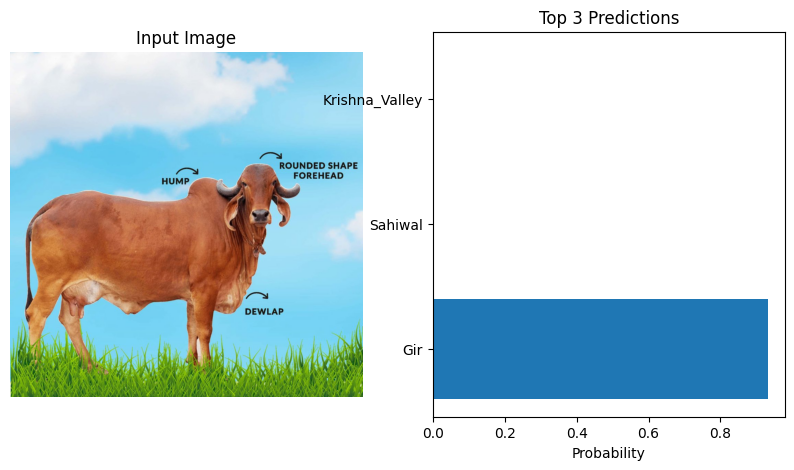

In [76]:
predict_breed(model, '/kaggle/input/indian-cattle-image-dataset/cattle/Gir/Gir_104.jpg', idx_to_class, device)

### Created with passion and persistence! hope you found it useful or inspiring ✨